In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# librosa has some depreciated code which throws a warning
import librosa as lbs
import librosa.display as lbsd
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

## Exploring Audio Data Waveforms

#### Lets see what librosa can to to help understand the waveform
First load up a sample waveform and see what it contains

In [4]:
mainPath = "/Users/nicholas/Desktop/Misc/Workspace/PythonWorkspace/musicProject/musicdata"

y, sr = lbs.load(mainPath + "/genres_original/reggae/reggae.00019.wav")

print("y:", y)
print("y shape:" ,np.shape(y))
print("sample rate:", sr)
print("length of file in seconds:", len(y)/sr)

y: [-0.02355957 -0.03036499 -0.02444458 ...  0.00683594  0.00024414
 -0.00888062]
y shape: (661794,)
sample rate: 22050
length of file in seconds: 30.013333333333332


Good practice to trim silence from beginning and end of file

In [5]:
audioData = lbs.effects.trim(y)[0]

print("Audio Data:", audioData)
print("Audio Data Shape:", np.shape(audioData))

Audio Data: [-0.02355957 -0.03036499 -0.02444458 ...  0.00683594  0.00024414
 -0.00888062]
Audio Data Shape: (661794,)


#### Lets see how the waveform looks with amplitude over time

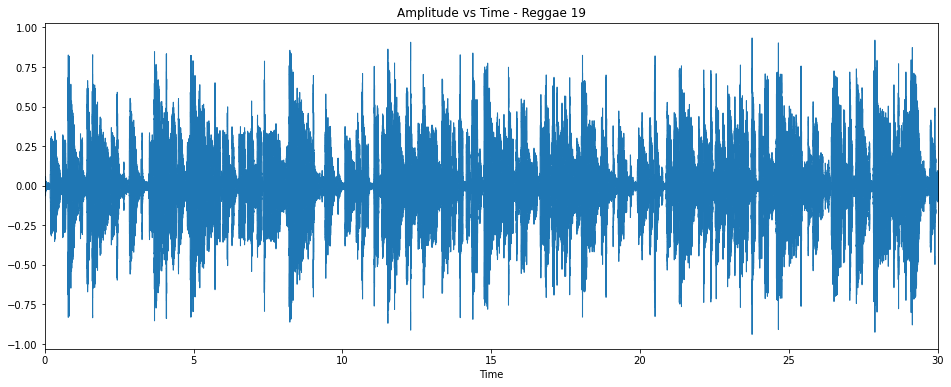

In [6]:
# setup matplotlib figure
plt.figure(figsize = (16, 6))

lbsd.waveshow(audioData, sr);
plt.title("Amplitude vs Time - Reggae 19");
plt.xlim([0,30]);

### Now lets look at more insightful methods of expressing this waveform
#### Firstly, lets generate a fourier transform to see signal in frequency domain

In [13]:
# var for fft window size
fftWindow = 2048
fftShift = 256
S = np.abs(lbs.stft(audioData, n_fft=fftWindow, hop_length=fftShift))

print("Shape of S:", np.shape(S))

Shape of S: (1025, 2586)


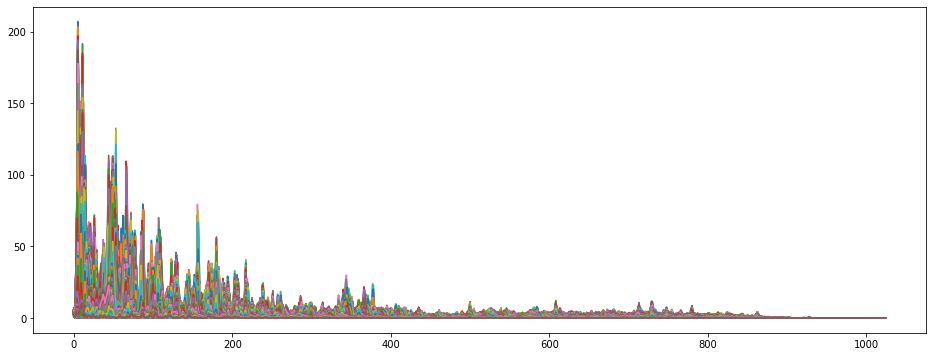

In [10]:
plt.figure(figsize=(16,6))
plt.plot(S);

#### Generating Spectrograms
Spectrograms are visual representations of a waveform in the frequency domain
These might be important for teaching the computer what a certain type of song (or audio file might look like)

They are also called voiceprints (HINT), these are the key to ML with audio data later on when generating MFCC

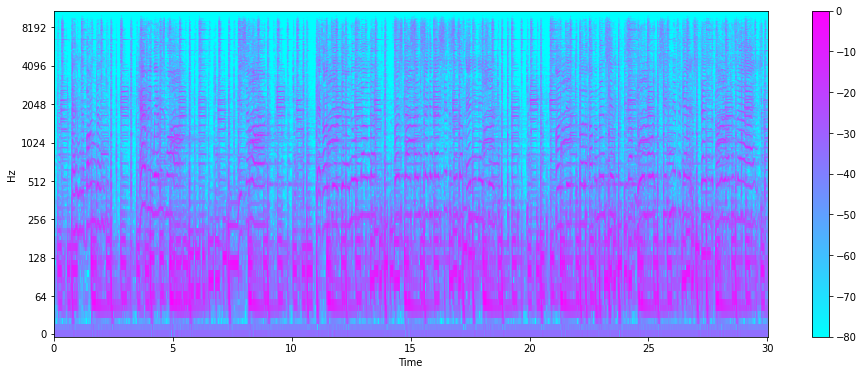

In [18]:
# convert amplitude to decibels (ELEC 251 lol)
dbS = lbs.amplitude_to_db(S, ref = np.max)

plt.figure(figsize=(16,6))
lbs.display.specshow(dbS, sr = sr, hop_length = fftShift, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();

Converting to the Mel Scale - the mel scale is a non-linear transformation of the frequency (y axis)

The Mel scale is based on how people can distingush between frequencies

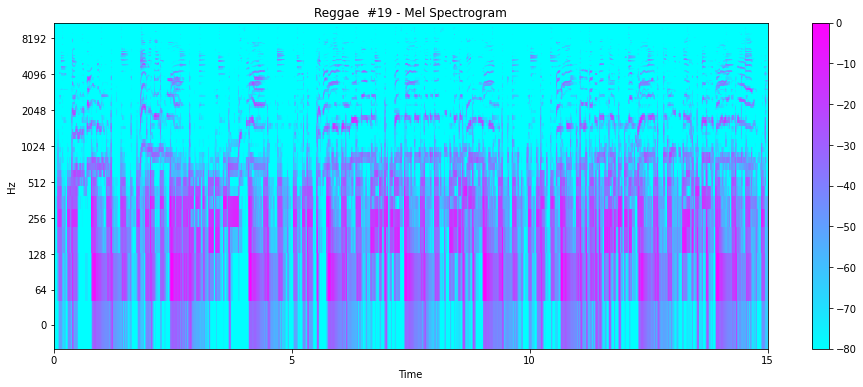

In [23]:
melS = lbs.feature.melspectrogram(y, sr=sr)
dbMelS = lbs.amplitude_to_db(melS, ref=np.max)

plt.figure(figsize=(16,6))
lbs.display.specshow(dbMelS, sr = sr, hop_length = fftShift, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Reggae  #19 - Mel Spectrogram");

#### Another example from a different genre

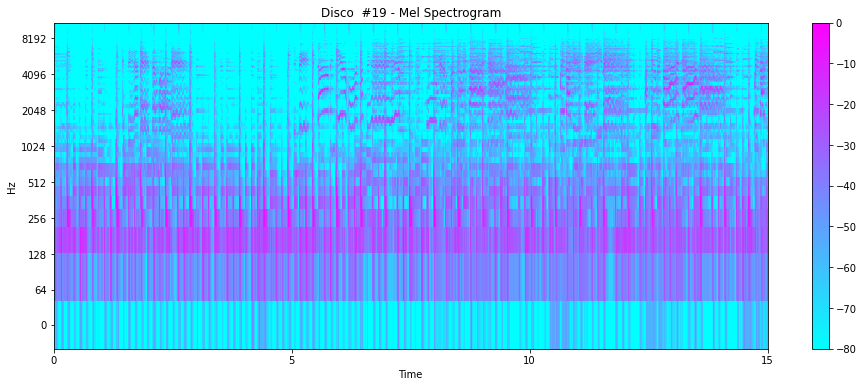

In [24]:
y, sr = lbs.load(mainPath + "/genres_original/disco/disco.00019.wav")
melS = lbs.feature.melspectrogram(y, sr=sr)
dbMelS = lbs.amplitude_to_db(melS, ref=np.max)

plt.figure(figsize=(16,6))
lbs.display.specshow(dbMelS, sr = sr, hop_length = fftShift, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Disco  #19 - Mel Spectrogram");

### MFCC - Mel Frequency Ceptstral Coefficients
#### A standardized method for getting a small set of features (dimensionality reduction) to describe the overall waveform - mainly used in voice recognition

MFCC Shape: (20, 1293)
Mean: 2.5077282e-09
Variance: 1.0


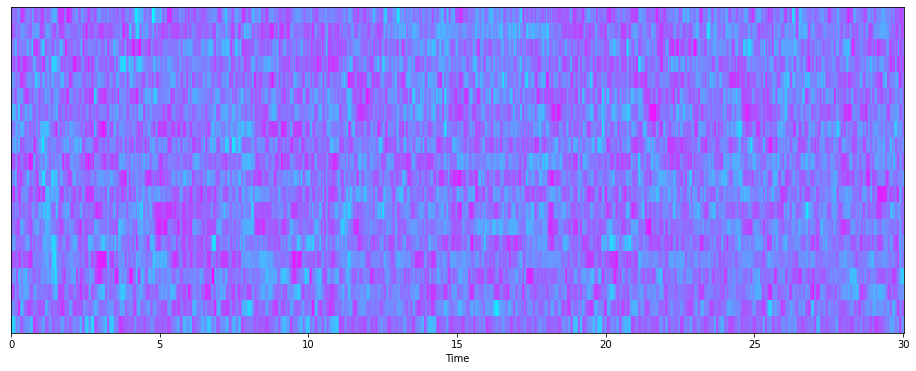

In [26]:
import sklearn
mfccs = lbs.feature.mfcc(audioData, sr=sr)
print("MFCC Shape:", mfccs.shape)

# normalize with sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)

print("Mean:", mfccs.mean())
print("Variance:", mfccs.var())

plt.figure(figsize=(16,6))
lbsd.specshow(mfccs, sr=sr, x_axis='time', cmap='cool');

### Fun Time - what generic info can we extract from the audio data?
#### Tempogram

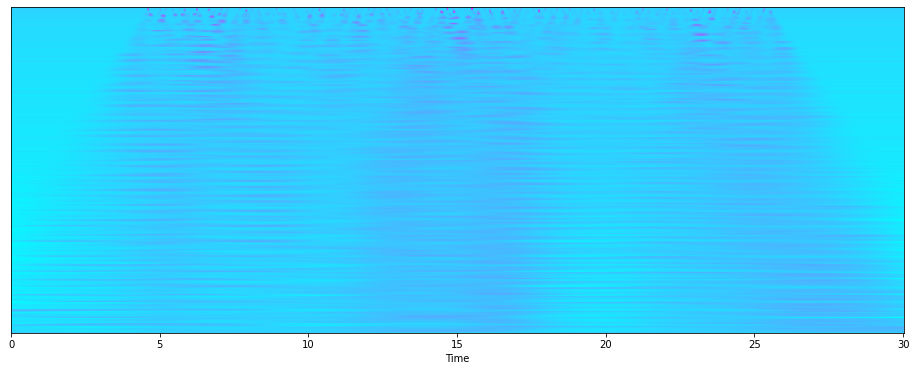

In [28]:
tempogram = lbs.feature.tempogram(audioData, sr=sr)
tempogram = sklearn.preprocessing.scale(tempogram, axis=1)
plt.figure(figsize=(16,6))
lbsd.specshow(tempogram, sr=sr, x_axis='time', cmap='cool');

#### Harmonics - I have no idea what these are for but they look interesting

Given a frequency-based energy representation such as a spectrogram or tempogram, this function computes the energy at the chosen harmonics of the frequency axis. The resulting harmonic array can then be used as input to a salience computation.

(5, 384)


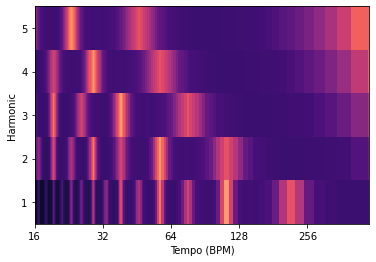

In [31]:
# Compute the time-varying tempogram and average over time
tempi = np.mean(lbs.feature.tempogram(y=y, sr=sr), axis=1)
# We'll measure the first five harmonics
harmonics = [1, 2, 3, 4, 5]
f_tempo = lbs.tempo_frequencies(len(tempi), sr=sr)
# Build the harmonic tensor; we only have one axis here (tempo)
t_harmonics = lbs.interp_harmonics(tempi, freqs=f_tempo, harmonics=harmonics, axis=0)
print(t_harmonics.shape)

fig, ax = plt.subplots();
lbs.display.specshow(t_harmonics, x_axis='tempo', sr=sr, ax=ax);
ax.set(yticks=np.arange(len(harmonics)),
       yticklabels=['{:.3g}'.format(_) for _ in harmonics],
       ylabel='Harmonic', xlabel='Tempo (BPM)');